<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 - AutoEncoder
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [1]:
# Set your student number
student_number = 97101489
Name = 'Amirhosein'
Last_Name = 'Javadi'

# Rules
- You **are** allowed to add or remove cells.
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [2]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q3.ipynb")
with open(f'python_code_Q3_{student_number}.py', 'w') as file:
    file.write(python_code)

your jupyter file won't be graded
collectable cells' count must be 42 instead found 1
cell count must be 60 instead found 11


# Autoencoders (20 Extra Points)

<font size=4>
Author: Ahmad Salimi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

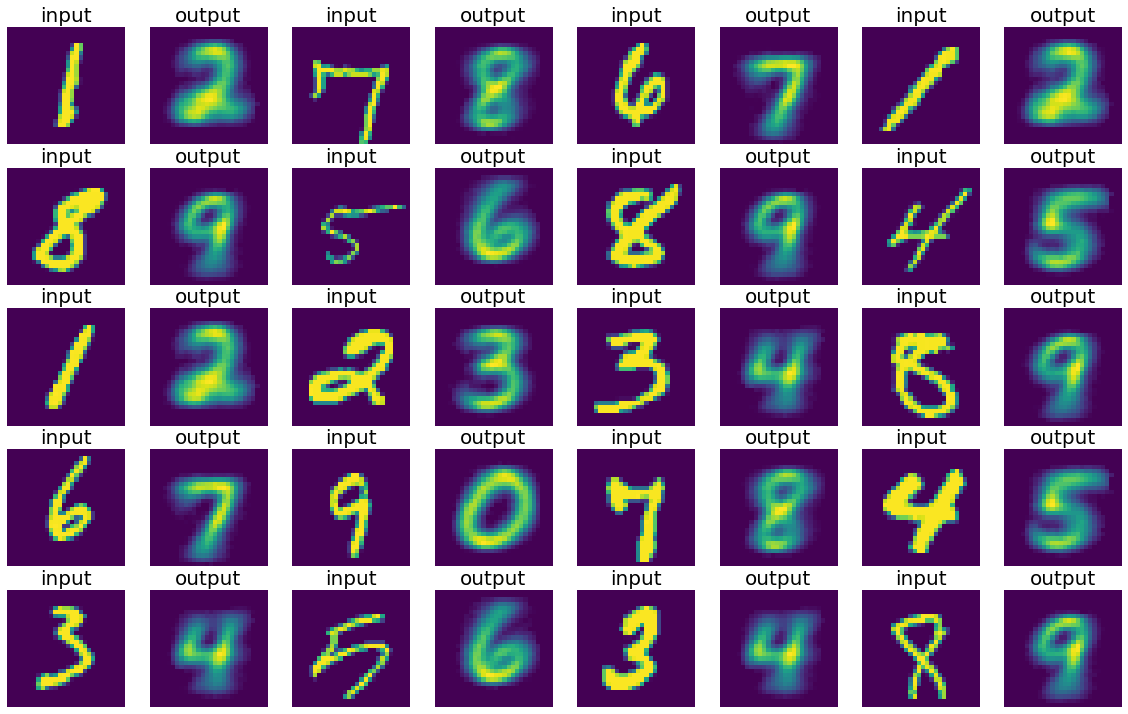

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [71]:
from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [147]:
 class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),   # (8,14,14)
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=3, padding=1),  # (16,5,5)
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=3, padding=1), # (32,2,2)
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(2* 2 * 32, 32),  # (32)
            nn.ReLU(True),
            nn.Linear(32, 4) # (4)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(4, 64),  # (64)
            nn.ReLU(True),
            nn.Linear(64, 2 * 2 * 32),  # (128)
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 2, 2))   # (32,2,2)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # (16,4,4)
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, output_padding=1), # (8,10,10)
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=3, padding=1)  # (1,28,28)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [148]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int): #-> Tuple[torch.Tensor, ...]:
  #   def __getitem__(self, i: int):
        return self.X[i], self.Y[i], self.y[i]

In [149]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=512,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=1024,
    shuffle=False
)

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [188]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
encoder = Encoder()
decoder = Decoder()
encoder.to(device)
decoder.to(device)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

torch.manual_seed(0)
#model = Autoencoders()
#criterion = nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params_to_optimize,
                             lr = 1e-3,
                             weight_decay = 1e-5)

cpu


## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [190]:
num_epochs= 40
train_batch_size = 512
val_batch_size = 1024
encoder.train()
decoder.train()
train_loss_arr, val_loss_arr = [], []
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    for step, (x, y, z) in enumerate(train_dataloader): 
        x_r = np.reshape(x,[-1,1,28,28])
        y_r = np.reshape(y,[-1,1,28,28])
        x_r = x_r.to(device)
        y_r = y_r.to(device)
        encoded_data = encoder(x_r)
        decoded_data = decoder(encoded_data)
        
        #print(decoded_data[0])
        #print(y_r[0])
        
        #break
    #break
        loss = criterion(decoded_data, y_r)
        train_loss += float(loss) * train_batch_size
        #print(float(loss) * train_batch_size)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    for step, (x, y, z) in enumerate(val_dataloader): 
        x_r = np.reshape(x,[-1,1,28,28])
        y_r = np.reshape(y,[-1,1,28,28])
        x_r = x_r.to(device)
        y_r = y_r.to(device)
        encoded_data = encoder(x_r)
        decoded_data = decoder(encoded_data)
        loss = criterion(decoded_data, y_r)
        val_loss += float(loss) * val_batch_size
        
    train_loss /= len(train_dataloader.dataset)
    val_loss /= len(val_dataloader.dataset)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    print(f"[Epoch {epoch}]\t"
        f"Train Loss: {train_loss:.4f}\t"
        f"Validation Loss: {val_loss:.4f}")

[Epoch 0]	Train Loss: 0.0679	Validation Loss: 0.0727
[Epoch 1]	Train Loss: 0.0657	Validation Loss: 0.0710
[Epoch 2]	Train Loss: 0.0645	Validation Loss: 0.0699
[Epoch 3]	Train Loss: 0.0636	Validation Loss: 0.0691
[Epoch 4]	Train Loss: 0.0630	Validation Loss: 0.0685
[Epoch 5]	Train Loss: 0.0625	Validation Loss: 0.0680
[Epoch 6]	Train Loss: 0.0620	Validation Loss: 0.0675
[Epoch 7]	Train Loss: 0.0615	Validation Loss: 0.0670
[Epoch 8]	Train Loss: 0.0610	Validation Loss: 0.0665
[Epoch 9]	Train Loss: 0.0605	Validation Loss: 0.0660
[Epoch 10]	Train Loss: 0.0601	Validation Loss: 0.0656
[Epoch 11]	Train Loss: 0.0598	Validation Loss: 0.0652
[Epoch 12]	Train Loss: 0.0594	Validation Loss: 0.0649
[Epoch 13]	Train Loss: 0.0591	Validation Loss: 0.0646
[Epoch 14]	Train Loss: 0.0588	Validation Loss: 0.0643
[Epoch 15]	Train Loss: 0.0585	Validation Loss: 0.0639
[Epoch 16]	Train Loss: 0.0582	Validation Loss: 0.0636
[Epoch 17]	Train Loss: 0.0579	Validation Loss: 0.0634
[Epoch 18]	Train Loss: 0.0577	Validati

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

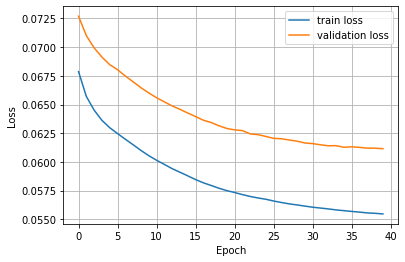

In [191]:
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'])
plt.grid()
plt.show()

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

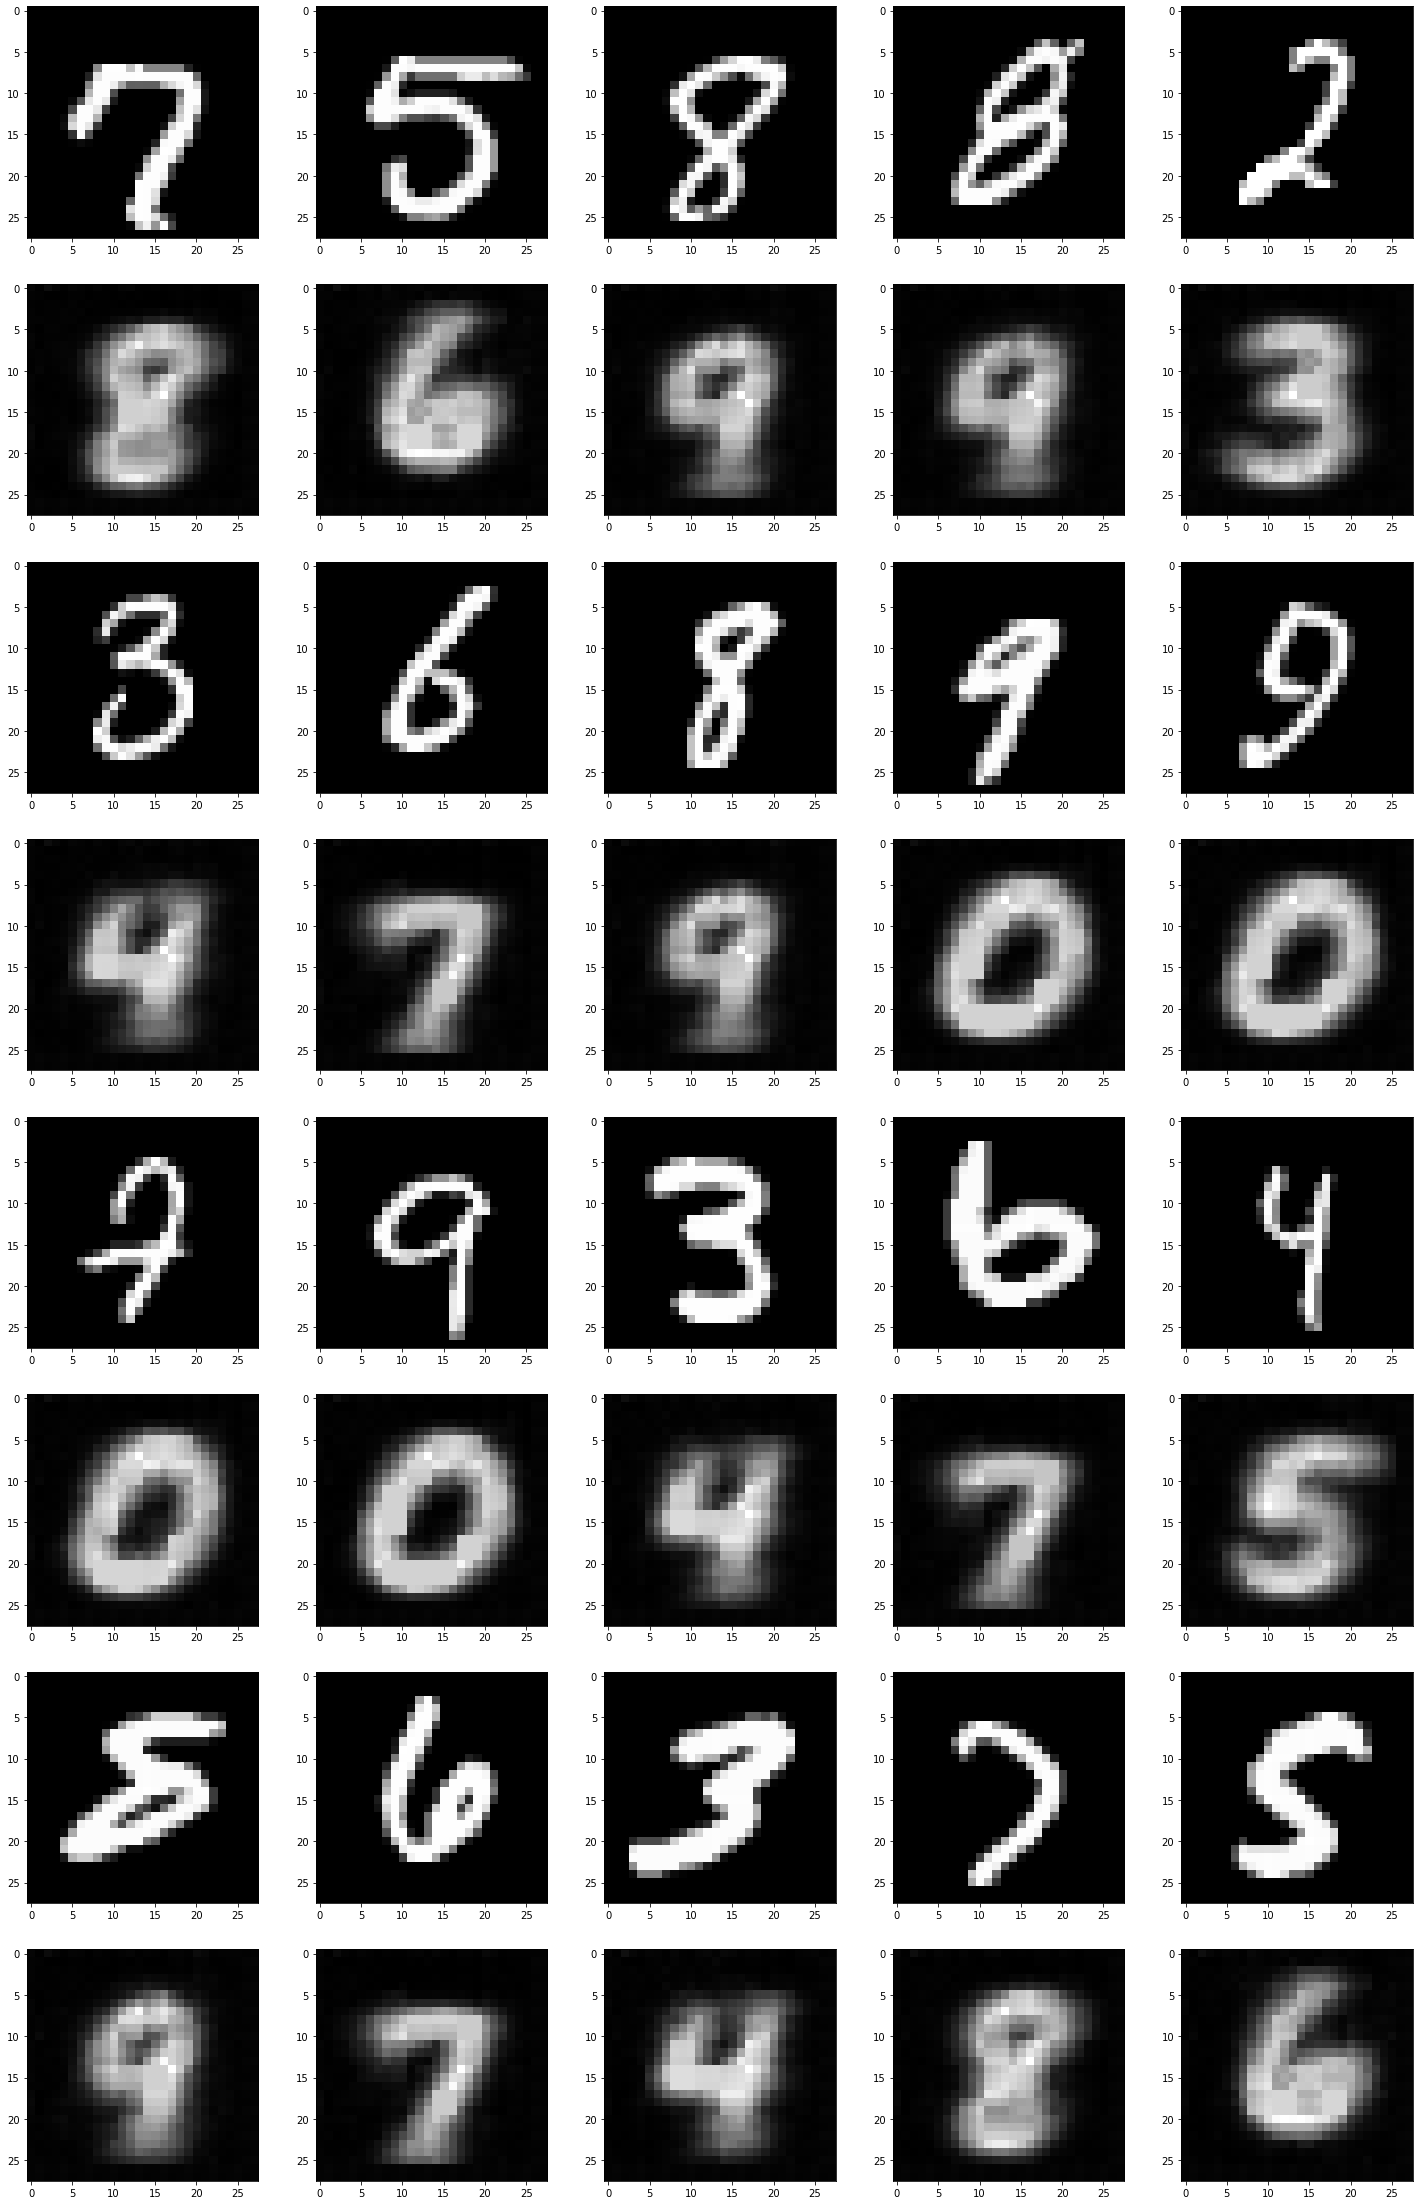

In [204]:
fig, axs = plt.subplots(8, 5, figsize=(25, 40))
counter = 0
Flag = True
for step, (x, y, z) in enumerate(val_dataloader): 
    if Flag == False:
        break
    x_r = np.reshape(x,[-1,1,28,28])
    y_r = np.reshape(y,[-1,1,28,28])
    x_r = x_r.to(device)
    y_r = y_r.to(device)
    encoded_data = encoder(x_r)
    decoded_data = decoder(encoded_data)
    predictions = decoded_data.argmax(-1)
    n = int(predictions.size(dim=0))
    for i in range(n):
        image1 = np.reshape(x[i].numpy(),[28,28])
        image2 = np.reshape(decoded_data[i].detach().numpy(),[28,28])
        if counter<5:
            axs[0, counter].imshow(image1*255, cmap='gray')
            axs[1, counter].imshow(image2*255, cmap='gray')
            counter += 1
        elif counter<10:
            axs[2, counter-5].imshow(image1*255, cmap='gray')
            axs[3, counter-5].imshow(image2*255, cmap='gray')
            counter += 1
        elif counter<15:
            axs[4, counter-10].imshow(image1*255, cmap='gray')
            axs[5, counter-10].imshow(image2*255, cmap='gray')
            counter += 1
        elif counter<20:
            axs[6, counter-15].imshow(image1*255, cmap='gray')
            axs[7, counter-15].imshow(image2*255, cmap='gray')
            counter += 1
        else:
            Flag = False
            break
            
    